In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
# check for cuda, check for type of device and print
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Using device: cuda
NVIDIA GeForce RTX 4090


In [3]:
# basic implementation of a 2D wave equation with reflecting conditions using a finite difference scheme
# the wave equation is given by:
# d^2/dt^2 u = d^2/dx^2 u + d^2/dy^2 u
# where u is the wave function and x and y are the spatial coordinates
# convert to first order form:
# d/dx u = u_x
# d/dy u = u_y
# d/dt u = v

# equations become (first order form):
# d/dt v = d/dx u_x + d/dy u_y
# d/dt u_x = d/dx v
# d/dt u_y = d/dy v
# d/dt u = v

In [ ]:
x_min, x_max = -1, 1
y_min, y_max = -1, 1
alpha = 0.5

nx = 128
ny = 128
nt = 16

x = torch.linspace(x_min, x_max, nx, device=device)
y = torch.linspace(y_min, y_max, ny, device=device)

u_n = torch.zeros(nx, ny, device=device)
v_n = torch.zeros(nx, ny, device=device)
ux_n = torch.zeros(nx, ny, device=device)
uy_n = torch.zeros(nx, ny, device=device)

u_np1 = torch.zeros(nx, ny, device=device)
v_np1 = torch.zeros(nx, ny, device=device)
ux_np1 = torch.zeros(nx, ny, device=device)
uy_np1 = torch.zeros(nx, ny, device=device)

dx = x[1] - x[0]
dy = y[1] - y[0]
dt = alpha * min(dx, dy)

In [ ]:
def ddx(f, dx):
    aux_x = torch.zeros_like(f)
    aux_x[1:-1,:] = (f[2:,:] - f[0:-2,:])/(2*dx)
    aux_x[ 0,:] = (-3/2*f[ 0,:] + 2*f[ 1,:] - 1/2*f[ 2,:])/dx
    aux_x[-1,:] = (+3/2*f[-1,:] - 2*f[-2,:] + 1/2*f[-3,:])/dx 
    return aux_x

def ddy(f, dy):
    aux_y = torch.zeros_like(f)
    aux_y[:,1:-1] = (f[:,2:] - f[:,0:-2])/(2*dy)
    aux_y[:, 0] = (-3/2*f[:, 0] + 2*f[:, 1] - 1/2*f[:, 2])/dy
    aux_y[:,-1] = (+3/2*f[:,-1] - 2*f[:,-2] + 1/2*f[:,-3])/dy
    return aux_y

# d/dt v = d/dx u_x + d/dy u_y
# d/dt u_x = d/dx v
# d/dt u_y = d/dy v
# d/dt u = v
def forward_euler_interior(fields, dx, dy, dt):
    u_n = fields.u_n
    v_n = fields.v_n
    ux_n = fields.ux_n
    uy_n = fields.uy_n

    u_np1 = fields.u_np1
    v_np1 = fields.v_np1
    ux_np1 = fields.ux_np1
    uy_np1 = fields.uy_np1

    v_np1[:,:]  = v_n[:,:]  + dt * (ddx(ux_n, dx) + ddy(uy_n, dy))
    ux_np1[:,:] = ux_n[:,:] + dt * ddx(v_n, dx)
    uy_np1[:,:] = uy_n[:,:] + dt * ddy(v_n, dy)
    u_np1[:,:]  = u_n[:,:]  + dt * v_n[:,:]

def set_odd_x(f):
    f[ 0,:] = 0
    f[-1,:] = 0

def set_odd_y(f):
    f[:, 0] = 0
    f[:,-1] = 0

def set_even_x(f):
    f[ 0,:] = 4/3*f[ 1,:] - 1/3*f[ 2,:]
    f[-1,:] = 4/3*f[-2,:] - 1/3*f[-3,:]

def set_even_y(f):
    f[:, 0] = 4/3*f[:, 1] - 1/3*f[:, 2]
    f[:,-1] = 4/3*f[:,-2] - 1/3*f[:,-3]

def forward_euler(fields, dx, dy, dt):
    u_np1 = fields.u_np1
    v_np1 = fields.v_np1
    ux_np1 = fields.ux_np1
    uy_np1 = fields.uy_np1

    forward_euler_interior(fields, dx, dy, dt)

    # u and v are zero at the boundaries
    set_odd_x(u_np1)
    set_odd_y(u_np1)
    set_odd_x(v_np1)
    set_odd_y(v_np1)
    # u is odd at the x boundary therefore ux is even
    set_even_x(ux_np1)
    set_odd_y(ux_np1)
    # u is odd at the y boundary therefore uy is even
    set_odd_x(uy_np1)
    set_even_y(uy_np1)


In [ ]:
# initialize the wave function as a gaussian at 0, 0
# sigma = 0.25
# for i in range(nx):
#     for j in range(ny):
#         u_n[i, j] = torch.exp(-(x[i] ** 2 + y[j] ** 2) / sigma**2)
# doing it in a more efficient way

sigma = 0.25
X, Y = torch.meshgrid(x, y, indexing='ij')
u_n = torch.exp(-(X ** 2 + Y ** 2) / sigma**2)

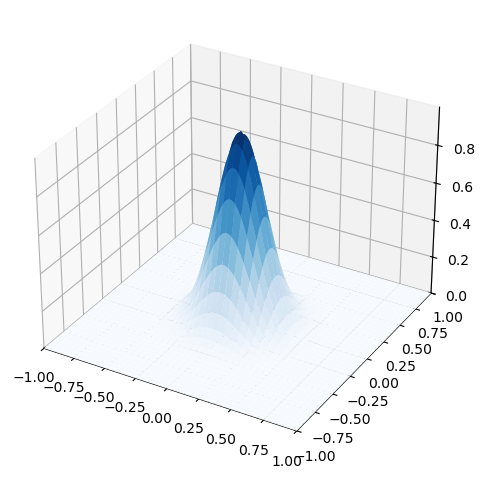

In [8]:
X, Y = np.meshgrid(x.cpu().numpy(), y.cpu().numpy())
U = u_n.cpu().numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(X,Y,U, cmap=cm.Blues)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_zlim(np.min(U), np.max(U))
plt.tight_layout()
plt.show()